In this experiment, we cluster wikidata contributors using K-means algorithm. Our data has the following schema:

    userId, kscore, nweeks
    
First, we prepare the data for our clustering process.

In [25]:
numberOfWeeks = 233

In [26]:
import networkx as nx
    
def extractTime(line, delim):
    v = line.split(delim)
    return v[2]

def extractEdge(line, delim):
    v = line.split(delim)
    return v[0]+ ';' + v[1]


# function load wtpGraph
def createGraph(pathtographfile, delim, artifact):
    f = open(pathtographfile, 'r')
    edges = set();
    # collect edges
    for line in f:
        line = line.rstrip()
        edges.add(extractEdge(line, delim))
    
    # build graphs
    G = nx.DiGraph()
    for e in edges:
        v = e.split(delim)
        G.add_edge(v[0],v[1])
    return G

# load wtpNetwork
wtpNetwork = createGraph(pathtographfile="../data/wtp-networksv2/wtpnetwork_timestamp.csv", delim=";", artifact=False)

# compute kcore
wtpNetwork.remove_edges_from(wtpNetwork.selfloop_edges())
userToCoreNumber = nx.core_number(wtpNetwork)
# compute nWeeks
def computeWeeklyUsers(pathToDataFile):
    f = open(pathToDataFile, 'r')
    users = []
    for l in f:
        items = l.split(";")
        users.append(items[0])
        users.append(items[1])
    return set(users)  

def computeListOfWeeklyUsers(filePrefix, numberOfWeeks):
    result = []
    for i in range(0,numberOfWeeks+1):
        result.append(computeWeeklyUsers(filePrefix + str(i)))
    return result

userToWeeks = dict()
weeklyUsers = computeListOfWeeklyUsers(filePrefix="../data/wtp-networksv2//wtpnetwork_timestamp.csv_", numberOfWeeks=numberOfWeeks)
for week in weeklyUsers:
    for u in week:
        if (u in userToWeeks):
            userToWeeks[u] = userToWeeks[u] + 1
        else:
            userToWeeks[u] = 1

In [27]:
import pandas as pd
import numpy as np

# create userList to serve as index of a pandas dataframe
users1 = set(userToCoreNumber.keys())
users2 = set(userToWeeks.keys())
userList = list(users1.intersection(users2))
# for u in userList:
#     if u == '':
#         userList.remove(u)
        
# create each user's kcorescore and nweeks
values = list()
for u in userList:
    user_values = list()
    user_values.append(userToCoreNumber[u])
    user_values.append(userToWeeks[u])
    values.append(user_values)

# create data frame
df = pd.DataFrame(np.array(values), index=userList, columns=['kcorescore','nweeks'], dtype='i')

Now we have prepared a data frame, df, we perform k-means clustering. But first let's just plot the data.

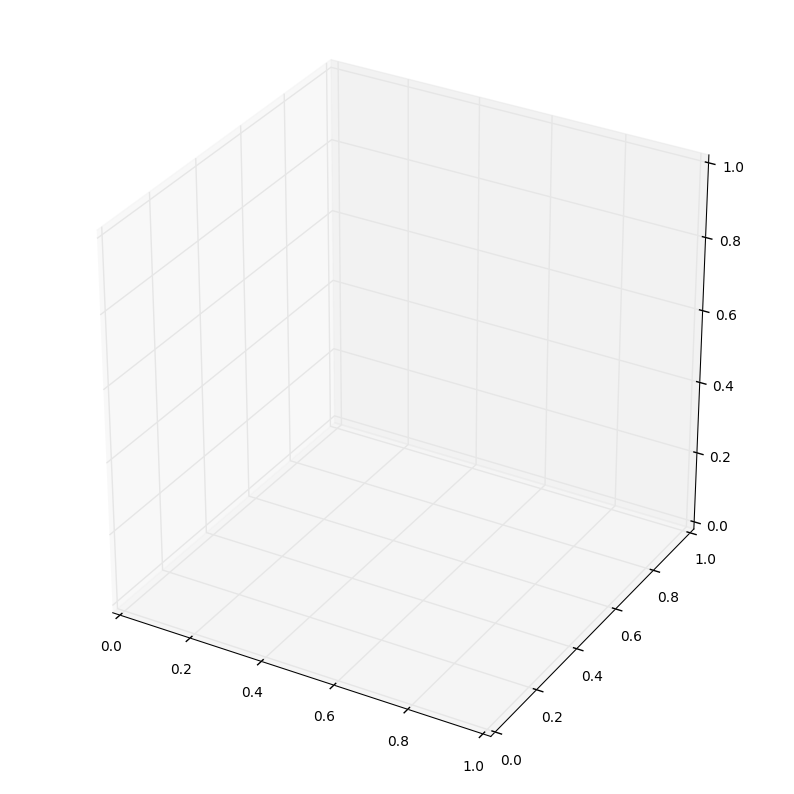

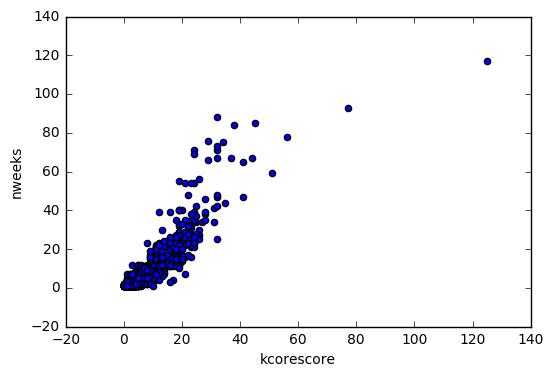

In [28]:
import matplotlib.pyplot as plt
df.plot.scatter(x='kcorescore', y='nweeks')
plt.show()

From the above plot we can see that *kcorescore* and *nweeks* are highly related. We need to have another feature to classier wikidata users. 

We define consistency of a user, denoted as $c(u)$ as follows:

$$c(u) = \frac{nweeks}{lasweek - firstweek}$$, $c(u) \in [0,1]$, where lastweek and endweek are the last week and the first week of parcipation for user $u$, respectively. Let's compute lastweek and endweek for each user.

In [29]:
filePrefix="../data/wtp-networksv2//wtpnetwork_timestamp.csv_"
def getUsers(pathToDataFile):
    f = open(pathToDataFile, 'r')
    users = []
    for l in f:
        items = l.split(";")
        users.append(items[0])
        users.append(items[1])
    f.close()
    return set(users)

userToFirstWeek = dict();
userToLastWeek = dict();

for w in range(0,numberOfWeeks +1):
    users = getUsers('../data/wtp-networksv2//wtpnetwork_timestamp.csv_' + str(w));
    for u in users:
        if u in userToFirstWeek:
            userToLastWeek[u] = w
        else:
            userToFirstWeek[u] = w
            
# user which appear first time in the last week of the study period will not have the last week appear so
# we need to add them
for u in userToFirstWeek:
    if not (u in userToLastWeek):
        userToLastWeek[u] = userToFirstWeek[u]
        

# compute consistency
userToConsistency = dict();
for u in userToFirstWeek:
    userToConsistency[u] =  (userToWeeks[u])/(userToLastWeek[u] - userToFirstWeek[u] + 1)

# we need to align consistency values with correct users in the data frame df
consistencyList = list();
for row in df.itertuples(index=True):
    u = row[0]
    consistencyList.append(userToConsistency[u])

df['consistency'] = np.array(consistencyList)




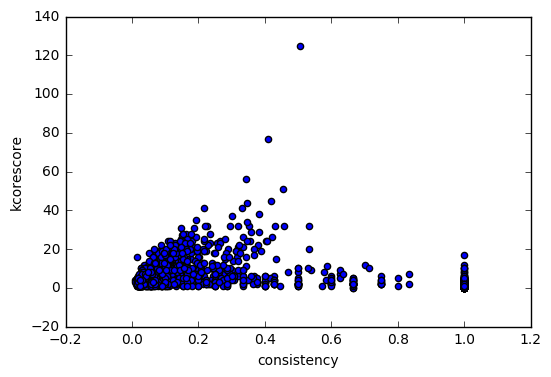

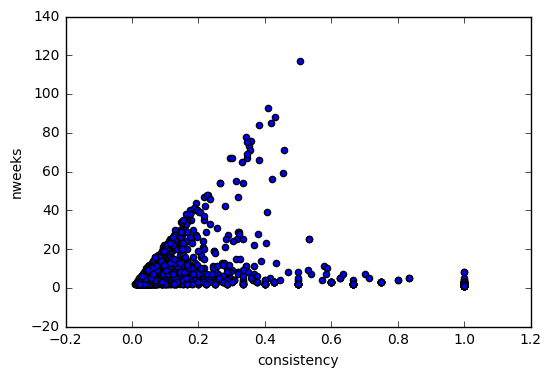

In [30]:
df.plot.scatter(x='consistency', y='kcorescore')
df.plot.scatter(x='consistency', y='nweeks')
plt.show()

In [31]:
df.corr()

,kcorescore,nweeks,consistency
kcorescore,1.000000,0.906974,-0.460617
nweeks,0.906974,1.000000,-0.399834
consistency,-0.460617,-0.399834,1.000000


We can see that the number of particpating weeks, nweeks, and k-core values, kscorescore, are highly correlated. Where consistence are highly uncorrelated with either of nweeks or kcorescore.

Because of our consistency definition, people with the highest consistency tends to be users that take part in less then 10% of study period.


Let's add another feature, namely 'artifact'. artifact is the number of artifact mention of the users in the study period.

In [32]:
import re as re

def getUserToArtifactCount(week):
    pattern = re.compile('^[QP]\d+')
    userToArtifactCount = dict()
    with open(filePrefix+str(week), 'r') as f:
        for l in f:
            v = l.split(';')
            usr1=v[0];
            if usr1 not in userToArtifactCount:
                userToArtifactCount[usr1] = 0
            usr2=v[1];
            if usr2 not in userToArtifactCount:
                userToArtifactCount[usr2] = 0
            if len(v) > 4:
                for t in v:
                    if re.search(pattern,t):
                        userToArtifactCount[usr1] = userToArtifactCount[usr1] +1
    return userToArtifactCount
                
userToArtifactCount = dict();
for w in range(0, numberOfWeeks+1):
    weeklyUserToArtifactCount = getUserToArtifactCount(w)
    for u in weeklyUserToArtifactCount:
        if u not in userToArtifactCount:
            userToArtifactCount[u] = weeklyUserToArtifactCount[u]
        else:
            userToArtifactCount[u] += weeklyUserToArtifactCount[u]
            
# again we need to align artifact count in df in the correct order
artifactCountList = list();
for row in df.itertuples(index=True):
    u = row[0]
    artifactCountList.append(userToArtifactCount[u])

df['artifact_count'] = np.array(artifactCountList)


In [33]:
df.corr()

,kcorescore,nweeks,consistency,artifact_count
kcorescore,1.000000,0.906974,-0.460617,0.528077
nweeks,0.906974,1.000000,-0.399834,0.592699
consistency,-0.460617,-0.399834,1.000000,-0.160632
artifact_count,0.528077,0.592699,-0.160632,1.000000


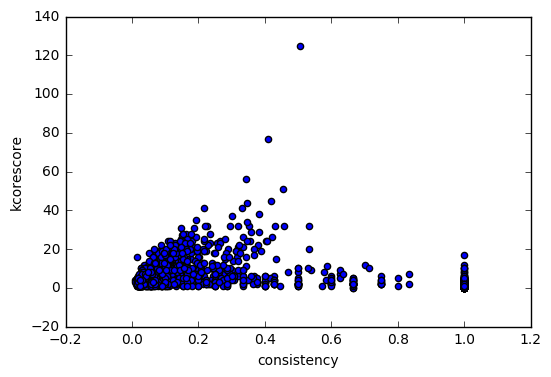

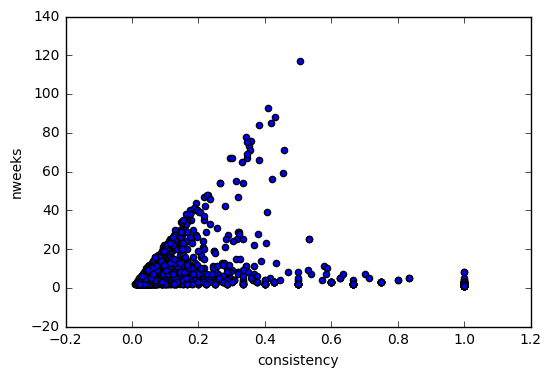

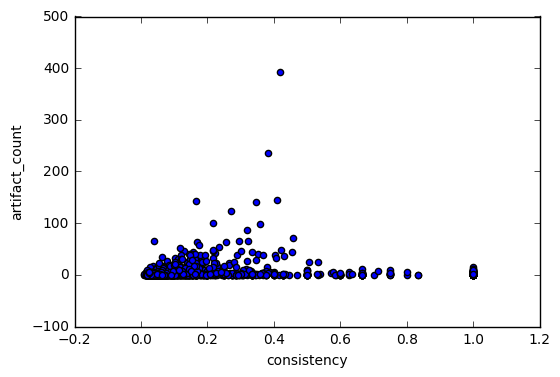

In [34]:
df.plot.scatter(x='consistency', y='kcorescore')
df.plot.scatter(x='consistency', y='nweeks')
df.plot.scatter(x='consistency', y='artifact_count')
plt.show()

Let's do the k-means clustering using k = 3. 

In [35]:
from sklearn import cluster, datasets

# perform clustering with k=3
X = df[['nweeks', 'consistency', 'artifact_count']].values
k_means = cluster.KMeans(n_clusters=3);
k_means.fit(X);




Let's visualize the data with cluster information

In [36]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(1, figsize=(1, 1))
# ax = Axes3D(fig, rect=[0, 0, 10, 10], elev=10, azim=175)
# labels = k_means.labels_
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float))

# ax.w_xaxis.set_ticklabels([])
# ax.w_yaxis.set_ticklabels([0, 100, 233])
# ax.w_zaxis.set_ticklabels([])
# ax.set_xlabel('nweeks')
# ax.set_ylabel('consitency')
# ax.set_zlabel('artifact_count')


# plt.show()



In [37]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.gca(projection='3d')
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]
ax.scatter(x, y, z, c = labels.astype(np.float))
ax.set_xlabel('nweeks')
ax.set_ylabel('consistency')
ax.set_zlabel('artifact_count')
ax.set_xlim(left=0, right=234)
ax.set_ylim(top=0, bottom=1)
ax.set_zlim(bottom=0, top=max(z))
plt.show()

ValueError: Color array must be two-dimensional

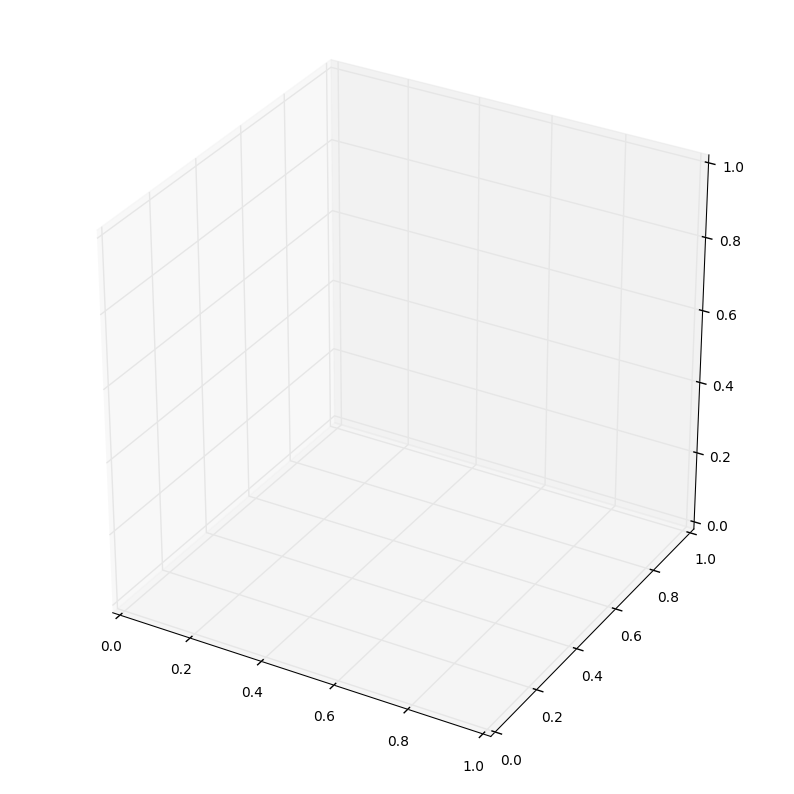

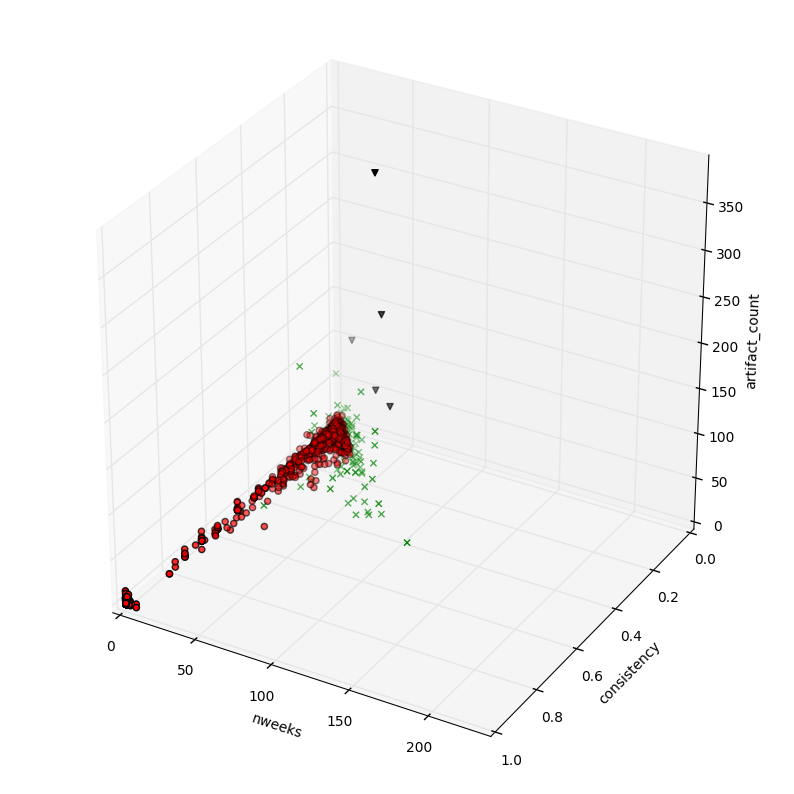

In [38]:
# ok we try better plotting
df['cluster'] = k_means.labels_
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.gca(projection='3d')
ax.set_xlabel('nweeks')
ax.set_ylabel('consistency')
ax.set_zlabel('artifact_count')
# ax.set_title('3-means clustering with original data')
ax.set_xlim(left=0, right=234)
ax.set_ylim(top=0, bottom=1)
ax.set_zlim(bottom=0, top=max(df['artifact_count']))
markers = ['o', 'x', 'v']
colors = ['r', 'green', 'black']
for i in range(min(df['cluster']), max(df['cluster']) +1):
    dfi = df[df['cluster'] == i]
    x = dfi['nweeks']
    y = dfi['consistency']
    z = dfi['artifact_count']
    labels = dfi['cluster']
    ax.scatter(x, y, z, c = colors[i], marker=markers[i])
plt.show()
   
    

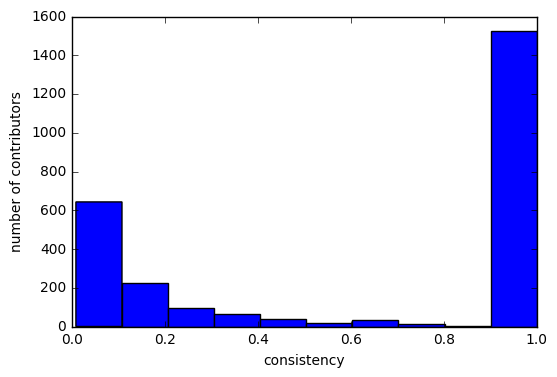

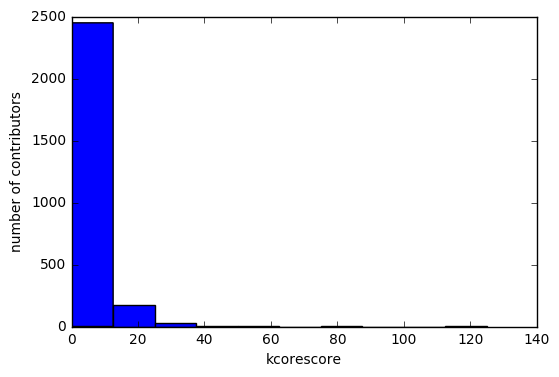

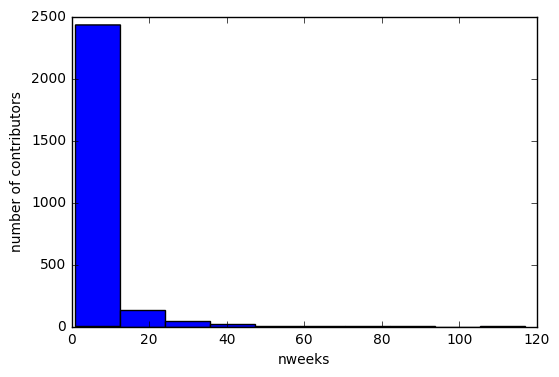

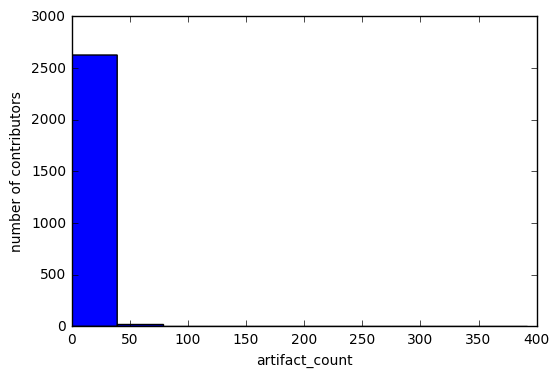

In [39]:
plt.hist(df['consistency'])
plt.xlabel('consistency')
plt.ylabel('number of contributors')
plt.show()
plt.hist(df['kcorescore'])
plt.xlabel('kcorescore')
plt.ylabel('number of contributors')
plt.show()
plt.hist(df['nweeks'])
plt.xlabel('nweeks')
plt.ylabel('number of contributors')
plt.show()
plt.hist(df['artifact_count'])
plt.xlabel('artifact_count')
plt.ylabel('number of contributors')
plt.show()


Maybe we should scale the data before performing k-means. 

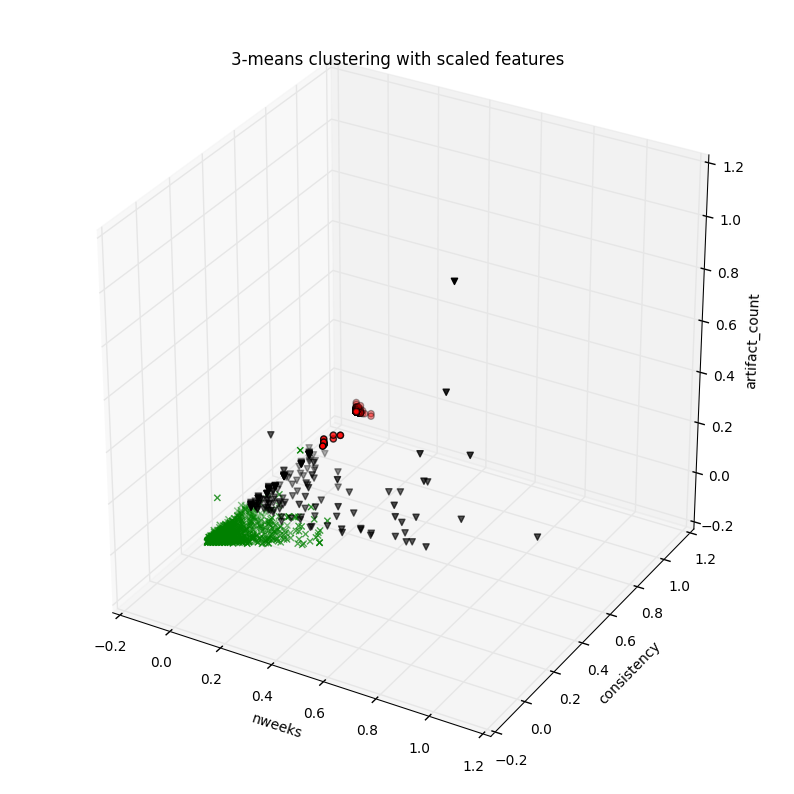

In [40]:
import pandas as pd
from sklearn import preprocessing

# scale and do k-means clustering
data = df[['nweeks', 'consistency', 'artifact_count']];
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(data)

# create new data frame for easy data manipulation
df_scaled = pd.DataFrame(data, columns=['nweeks', 'consistency', 'artifact_count'])
df_scaled['cluster'] = k_means.labels_

# now plot
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.gca(projection='3d', navigate=True)
# ax = Axes3D(fig, rect=[0, 0, 10, 10], elev=10, azim=175)
ax.set_xlabel('nweeks')
ax.set_ylabel('consistency')
ax.set_zlabel('artifact_count')
ax.set_title('3-means clustering with scaled features')
# elev=10, azim=175

markers = ['o', 'x', 'v']
colors = ['r', 'green', 'black']
for i in range(min(df_scaled['cluster']), max(df_scaled['cluster']) +1):
    dfi = df_scaled[df_scaled['cluster'] == i]
    x = dfi['nweeks']
    y = dfi['consistency']
    z = dfi['artifact_count']
    labels = dfi['cluster']
    ax.scatter(x, y, z, c = colors[i], marker=markers[i])
plt.show()

How about DBSCAN?

In [24]:
from sklearn import cluster;

db = cluster.DBSCAN(eps=0.6, min_samples=100).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

1


In [22]:
data

array([[ 0.04310345,  0.04229653,  0.00510204],
       [ 0.        ,  1.        ,  0.00255102],
       [ 0.10344828,  0.06906907,  0.0127551 ],
       ..., 
       [ 0.02586207,  0.02180043,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ]])